Reinforce算法中是以蒙特卡洛采样法来估计Q(state,action)的

Actor_Critic算法中以神经网络来估算Q(state,action)

再使用td误差来训练该神经网络


'''
。它點出了 Actor-Critic (AC) 演算法與前一章 REINFORCE 演算法的關鍵區別：

   1. REINFORCE 的做法：它需要跑完一整局遊戲 (Monte Carlo)，然後用整局的未來總獎勵 $G_t$ 來當作對 $Q(s_t, a_t)$
      的估計。這種方法雖然無偏差，但變異數很大，訓練不穩定。

   2. Actor-Critic 的做法：它引入了一個獨立的評審員 (Critic) 網路，這個網路的任務就是直接學習去估算 $Q(s, a)$ 或狀態價值
      $V(s)$。這樣就不需要等到整局遊戲結束。

   3. 訓練方式：Critic 網路本身是透過時間差分 (TD) 誤差來訓練的，這和 Q-Learning 或 SARSA 的更新方式很類似，使得 AC
      演算法可以進行單步更新，學習更穩定、更高效。

  總結來說，這個儲存格點明了 AC 演算法的核心精神：用一個 Critic 網路來取代 REINFORCE
  中的蒙地卡羅採樣，以降低變異數並提高學習效率。好的，我們接著看下一個儲存格。
'''

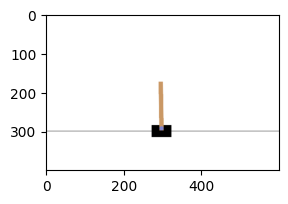

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [ ]:
import torch

#演员模型,计算每个动作的概率
model_actor = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

#评委模型,计算每个状态的价值
model_critic = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_critic_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_critic_delay.load_state_dict(model_critic.state_dict())

model_actor, model_critic




'''
  這個儲存格定義了 Actor-Critic (AC) 架構所需的三個核心神經網路模型。

   1. `model_actor` (演員模型):
       * 功能：這是策略 (Policy) 網路。它的任務是接收一個狀態 (state)，並輸出一組描述每個可能動作的機率。
       * 輸入：CartPole 環境的狀態，是一個包含 4 個數字的向量 (車位置、車速度、桿角度、桿角速度)。
       * 輸出：一個包含 2 個數字的向量，分別代表向左和向右移動的機率。
       * 關鍵層：最後一層是 Softmax，它能確保輸出值是介於 0 和 1 之間的機率，且總和為 1。

   2. `model_critic` (評審模型):
       * 功能：這是價值 (Value) 網路。它的任務是接收一個狀態，並評估這個狀態有多好，也就是估算這個狀態的價值 (State Value, V(s))。
       * 輸入：同樣是 4 維的狀態向量。
       * 輸出：一個純量 (scalar)，代表對當前狀態的價值評分。
       * 注意：在這個版本的 AC 中，Critic 估計的是 $V(s)$，而不是 $Q(s, a)$。

   3. `model_critic_delay` (延遲評審模型):
       * 功能：這是 Critic 模型的目標網路 (Target Network)，結構與 model_critic 完全相同。
       * 目的：它的作用與 DQN 中的 Target Network 一樣。在計算 TD 目標值時，我們使用這個參數更新較慢的 delay 模型來提供一個穩定的目標，避免因
         model_critic 自身參數的快速變動而導致的訓練震盪。
       * 初始化：model_critic_delay.load_state_dict(model_critic.state_dict()) 這行程式碼確保了在訓練開始時，目標網路的權重與主網路完全一致。

  總結來說，這個儲存格搭建了 AC 演算法的大腦：一個負責做決策的 Actor，以及一對負責評估決策好壞的 Critic 網路 (主網路和目標網路)。

'''

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
   (5): Softmax(dim=1)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=1, bias=True)
 ))

In [ ]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_actor(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum



'''
  這個儲存格定義了 play() 函式，這是智能體 (Agent) 與環境 (Environment) 互動的核心。

  函式功能：

   1. 執行一場完整的遊戲：
       * 從 env.reset() 開始，進入一個 while 迴圈，直到遊戲結束 (o 變為 True)。

   2. 決策與行動：
       * 在迴圈的每一步，它會：
           * 將當前狀態 s 輸入到 model_actor 中，獲得一個動作機率分佈 prob。
           * 使用 random.choices 根據這個機率分佈隨機採樣一個動作 a。這體現了策略梯度方法的核心——探索性。
           * 執行動作 a，並從環境中獲得新的狀態 ns、獎勵 r 和結束標誌 o。

   3. 記錄軌跡 (Trajectory)：
       * 它會將每一步的 (s, a, r, ns, o) 這個五元組分別儲存在對應的 list 中。

   4. 數據格式化：
       * 遊戲結束後，它會將記錄下來的 Python list 轉換為 PyTorch 的 Tensor，並調整好形狀 (shape)，以便後續輸入到神經網路中進行訓練。

   5. 回傳：
       * 函式最終回傳遊戲過程中的所有數據（狀態、動作、獎勵等），以及這一整局遊戲的總獎勵 `reward_sum`。

  執行部分：

   * state, action, reward, next_state, over, reward_sum = play() 這一行執行了 play 函式，跑了一局遊戲。
   * reward_sum 則顯示了這局遊戲的總得分。因為模型未經訓練，所以第一次玩的結果通常很差，得分會是一個很大的負數 (例如 -971.0)。

  總結來說，這個儲存格的功能是數據採集。它定義了一個完整的互動循環，讓 Agent
  根據當前策略玩遊戲，並把整個過程記錄下來，為接下來的訓練步驟準備好所需的數據。

'''

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\User\AppData\Local\Temp\ipykernel_54748\2154798901.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-971.0

In [4]:
optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=4e-3)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=4e-2)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [5]:
def train_critic(state, reward, next_state, over):
    requires_grad(model_actor, False)
    requires_grad(model_critic, True)

    #计算values和targets
    value = model_critic(state)

    with torch.no_grad():
        target = model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward

    #时序差分误差,也就是tdloss
    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_critic.step()
    optimizer_critic.zero_grad()

    return value.detach()


value = train_critic(state, reward, next_state, over)

value.shape

torch.Size([30, 1])

In [6]:
def train_actor(state, action, value):
    requires_grad(model_actor, True)
    requires_grad(model_critic, False)

    #重新计算动作的概率
    prob = model_actor(state)
    prob = prob.gather(dim=1, index=action)

    #根据策略梯度算法的导函数实现
    #函数中的Q(state,action),这里使用critic模型估算
    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()

    loss.backward()
    optimizer_actor.step()
    optimizer_actor.zero_grad()

    return loss.item()


train_actor(state, action, value)

-0.12820570170879364

In [7]:
def train():
    model_actor.train()
    model_critic.train()

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            value = train_critic(state, reward, next_state, over)
            loss = train_actor(state, action, value)

        #复制参数
        for param, param_delay in zip(model_critic.parameters(),
                                      model_critic_delay.parameters()):
            value = param_delay.data * 0.7 + param.data * 0.3
            param_delay.data.copy_(value)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -17.94116973876953 -979.4
100 -298.44775390625 -936.5
200 -240.7567901611328 -551.9
300 -159.66920471191406 -169.65
400 -124.30767059326172 39.25
500 -49.67599105834961 149.1
600 -56.38823699951172 200.0
700 -29.849672317504883 96.75
800 -22.606861114501953 200.0
900 -15.701851844787598 149.6


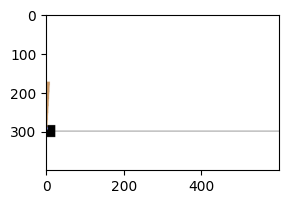

-815.0

In [8]:
play(True)[-1]